# LIBRARIES

In [1]:
import networkx as nx
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
from typing import Optional,Tuple

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATASET

In [2]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.to_device.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.25, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid(root='/train/Cora', name='Cora',transform=transform)
train_data, val_data, test_data = dataset[0]
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features,
    'graph' : dataset[0],
}

{'graph number': 1,
 'num_classes': 7,
 'num_node_features': 1433,
 'graph': (Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[3696], pos_edge_label_index=[2, 3696]),
  Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263]),
  Data(x=[2708, 1433], edge_index=[2, 7918], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[1319], pos_edge_label_index=[2, 1319], neg_edge_label=[1319], neg_edge_label_index=[2, 1319]))}

# MODEL

In [3]:
class GCN_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Encoder, self).__init__()
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar
    
class GCN_Pre_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Pre_Encoder, self).__init__()
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.preprocess = nn.Sequential(
            nn.Linear(in_channels,2*in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(2*in_channels),
            nn.Linear(2*in_channels,in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(in_channels),
            )
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.preprocess(x)
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class GAT_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,head=1):
        super(GAT_Encoder, self).__init__()
        self.preprocess = nn.Sequential(
            nn.Linear(in_channels,2*in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(2*in_channels),
            nn.Linear(2*in_channels,in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(in_channels),
            )
        self.gcn_shared = pyg_nn.GATv2Conv(in_channels, hidden_channels,head=head)
        self.gcn_mu = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)
        self.gcn_logvar = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)
        

    def forward(self, x, edge_index):
        x = self.preprocess(x)
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class Node_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Node_Decoder, self).__init__()
        self.fc_encoder = nn.Sequential(
            nn.Linear(output_dim,output_dim//4),
            nn.ReLU(),
            nn.BatchNorm1d(output_dim//4),
            nn.Linear(output_dim//4,latent_dim),
            nn.ReLU(),
        )
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim + latent_dim,hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim,output_dim),
            nn.Sigmoid(),
        )

    def forward(self,z,x):
        x = self.fc_encoder(x)
        x = torch.cat((x,z),dim=1)
        x = self.fc_decoder(x)
        return x

in_channels = train_data.num_node_features
hidden_channels = in_channels * 2
latent_dim = 32

In [4]:
@torch.no_grad()
def test_gae(gae_model,node_model,data):
    gae_model.eval()
    z = gae_model.encode(data.x, data.edge_index)
    auc,ap = gae_model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


    x = node_model(z,data.x)
    loss = F.mse_loss(x,data.x)
    loss = loss + gae_model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * gae_model.kl_loss()
    return loss.item(),auc,ap

# Training loop
def update_gae(gae_model,node_model,data,optimizer):
    gae_model.train()
    z = gae_model.encode(data.x, data.edge_index)

    x = node_model(z,data.x)
    loss = F.mse_loss(x,data.x)
    
    loss = loss + gae_model.recon_loss(z, data.edge_index)
    loss = loss + (1 / data.num_nodes) * gae_model.kl_loss()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_gae(gae_model,node_model,optimizer,hist,n):
    for epoch in range(n):
        loss = update_gae(gae_model,node_model,train_data,optimizer)
        hist['train']['loss'].append(loss)
        
        loss,auc,ap = test_gae(gae_model,node_model,test_data)
        hist['test']['loss'].append(loss)
        hist['test']['auc'].append(auc)
        hist['test']['ap'].append(ap)
        if (epoch+1) % 10 == 0 :
            from IPython.display import clear_output
            clear_output()
            print(f"average precision {ap:.4f}")
            plot_loss(hist)

def init_hist():
    hist = {'train':{},'test':{}}
    metrics = "loss auc ap node_loss"
    for mode in "train test".split():
        for m in metrics.split():
            hist[mode][m]=[]
    return hist

def plot_loss(hist):
    fig,axs = plt.subplots(1,3,figsize=(12,4))
    epoch = len(hist['train']['loss'])
    fig.suptitle(f'epoch - {epoch}')
    for ax,m in zip(axs.flatten(),hist['train'].keys()):
        ax.set_title(m)
        ax.plot(hist['train'][m],label='train')
        ax.plot(hist['test'][m],label='test')
        ax.legend()
    
    plt.show()
    
def test_node_decoder(gae_model,decoder,data):
    gae_model.eval()
    decoder.eval()
    z = gae_model.encode(data.x, data.edge_index)
    x = decoder(z,data.x)
    loss = F.mse_loss(x,data.x)
    return loss.item()


In [5]:
# model = pyg_nn.VGAE(GAT_Encoder(in_channels,hidden_channels,latent_dim))
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# hist = init_hist()
# train(model,optimizer,hist,150)
# hist['test']['ap'][-1]

In [6]:
# model = pyg_nn.VGAE(GCN_Pre_Encoder(in_channels,hidden_channels,latent_dim))
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

# hist = init_hist()

# train(model,optimizer,hist,300)
# hist['test']['ap'][-1]

average precision 0.9228


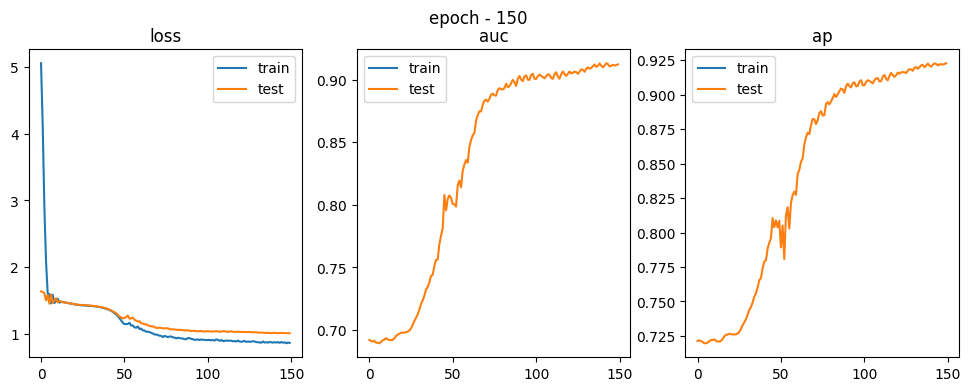

0.9228118513287371

In [7]:
gae_model = pyg_nn.VGAE(GCN_Encoder(in_channels,hidden_channels,latent_dim))
node_model = Node_Decoder(latent_dim,hidden_channels,in_channels)
gae_model = gae_model.to(device)
node_model = node_model.to(device)
params = list(gae_model.parameters()) + list(node_model.parameters())
optimizer = torch.optim.Adam(params,lr = 0.005)
hist = init_hist()
train_gae(gae_model,node_model,optimizer,hist,150)
hist['test']['ap'][-1]

# Thresholding

In [8]:
def fn(model,data,threshold=None):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    adj = model.decoder.forward_all(z)
    adj = adj.long() if threshold is None else adj >= threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]
    
    fn = lambda t : t.flatten().cpu().long()
    pred,target = fn(adj), fn(pyg_utils.to_dense_adj(val_data.edge_index))
    
    cm = confusion_matrix(target,pred)
    
    tn,fp = cm[0,:]
    fn,tp = cm[1,:]
    
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    acc = (tn+tp) / sum([tn,fn, fp, tp])
    f1 = (precision * recall)/(precision + recall)
    
    return {
        "ideal_cm":confusion_matrix(target,target),
        "cm": cm,
        "size_ratio": edge_index.shape[1]/data.edge_index.shape[1],
        "precision": precision,
        "recall": recall,
        "acc" : acc,
        "f1": f1
    }
'''
[[tn,fp], # n
 [fn,tp]] # p
'''
fn(gae_model,train_data,0.95)

{'ideal_cm': array([[7325872,       0],
        [      0,    7392]], dtype=int64),
 'cm': array([[7291823,   34049],
        [   3806,    3586]], dtype=int64),
 'size_ratio': 5.091314935064935,
 'precision': 0.0952836455427129,
 'recall': 0.4851190476190476,
 'acc': 0.9948379057401997,
 'f1': 0.07964110422635308}

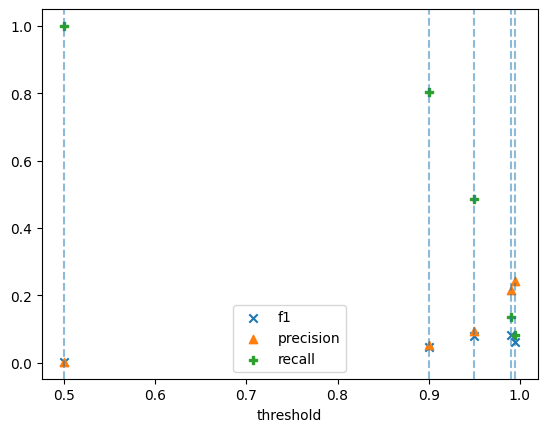

In [9]:
x = [0.5,0.9,0.95,0.99,0.995]
y = []
precision_hist = []
recall_hist = []
size_hist = []
for t in x:
    res = fn(gae_model,train_data,t)
    precision_hist.append(res['precision'])
    recall_hist.append(res['recall'])
    size_hist.append(res['size_ratio'])
    y.append(res['f1'])

[plt.axvline(1 if i is None else i,alpha=0.5,ls='--') for i in x]
plt.xlabel('threshold')
plt.scatter(x,y,label='f1',marker='x')
plt.scatter(x,precision_hist,label='precision',marker='^')
plt.scatter(x,recall_hist,label='recall',marker='P')
plt.legend()

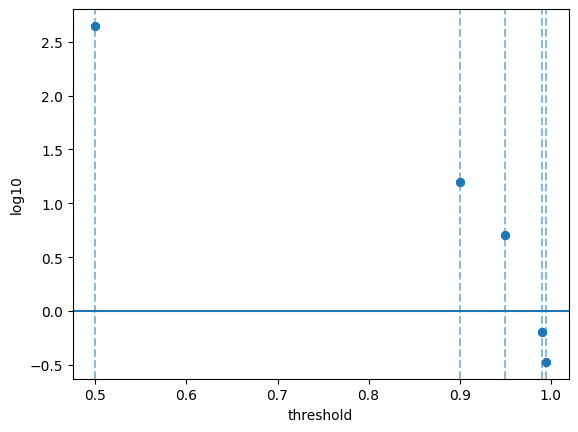

In [10]:
import numpy as np
plt.axhline(y=np.log10(1))
plt.ylabel('log10')
plt.xlabel('threshold')
[plt.axvline(1 if i is None else i,alpha=0.5,ls='--') for i in x]
plt.scatter(x,np.log10(size_hist),label='size_ratio',marker='8')

In [11]:
THRESHOLD = 0.99

In [12]:
def reconstruct_data(gae_model,node_model,data,threshold=None):
    z = gae_model.encode(data.x, data.edge_index)
    x = node_model(z,data.x).detach()
    adj = gae_model.decoder.forward_all(z).detach()
    # adj = adj > threshold
    adj = adj.long() if threshold is None else adj > threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]
    recon_data = Data(x=x,edge_index=edge_index,
                      y=data.y,
                      train_mask = data.train_mask,
                      test_mask = data.test_mask,
                      val_mask = data.val_mask)
    return recon_data.to(device)

# CROSS VALIDATION

In [13]:
dataset = Planetoid(root='/data/Cora', name='Cora')
data = dataset[0].to(device)

In [14]:
class GCN(nn.Module):
    def __init__(self,in_channels=dataset.num_node_features, 
                 hidden_channels = 16, out_channels = dataset.num_classes,seed=42):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def plot_loss(hist):
    plt.title(f'epoch - {len(hist["train"])}')
    plt.plot(hist['train'],label='train')
    plt.plot(hist['test'],label='test')
    plt.legend()
    plt.show()

def test(model,data):
    out = model(data)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc
    
def train(model,dataset,optimizer, hist, n = 100):
    for epoch in range(n):
        train_losses = []
        test_losses = []
        for data in dataset:
            model.train()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        
            model.eval()
            loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
            test_losses.append(loss.item())
        
        mean = lambda xs : torch.tensor(xs).mean()   
        hist['train'].append(mean(train_losses))
        hist['test'].append(mean(test_losses))
    
    plot_loss(hist)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')

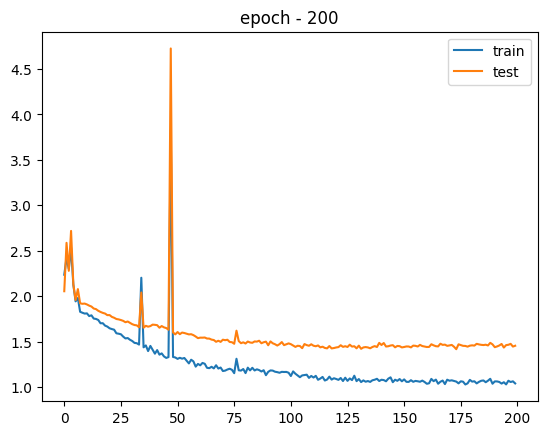

Accuracy: 0.1440


(0.144, 0.78)

In [15]:
classifier_model = GCN().to(device)
hist = {'train':[],'test':[]}
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
recon_data = reconstruct_data(gae_model,node_model,data,THRESHOLD)
train(classifier_model,[data,recon_data], optimizer, hist, n=200)
x1 = test(classifier_model,recon_data)
x2 = test(classifier_model,data)
x1,x2

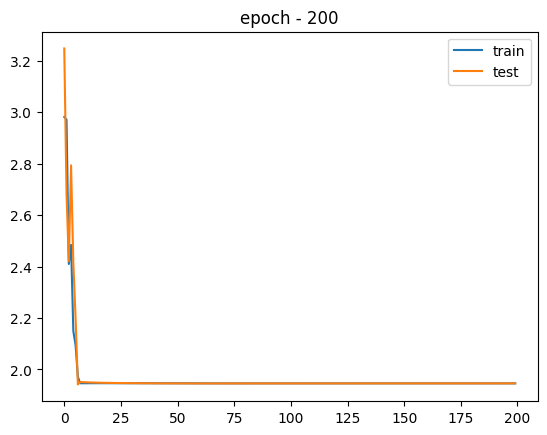

Accuracy: 0.0910


(0.091, 0.091)

In [16]:
classifier_model = GCN().to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
hist = {'train':[],'test':[]}
recon_data = reconstruct_data(gae_model,node_model,data)
train(classifier_model,[recon_data,recon_data], optimizer,hist,n=200)
x1 = test(classifier_model,recon_data)
x2 = test(classifier_model,data)
x1,x2

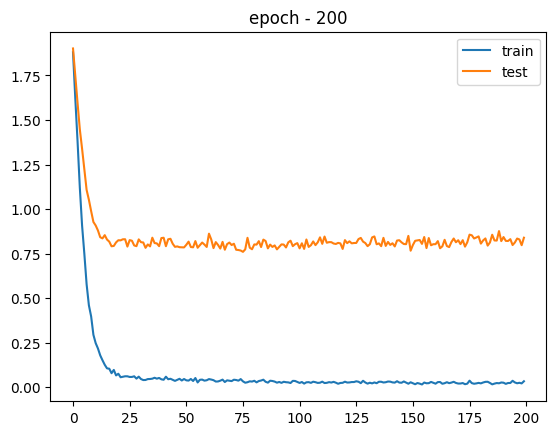

Accuracy: 0.8140


(0.319, 0.814)

In [17]:
classifier_model = GCN().to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
hist = {'train':[],'test':[]}
train(classifier_model,[data,data], optimizer,hist,n=200)

x1 = test(classifier_model,reconstruct_data(gae_model,node_model,data))
x2 = test(classifier_model,data)
x1,x2